# Visit individual Calexp_Background from Selected visits

- author Sylvie Dagoret-Campagne
- creation date 2024-05-04
- last update 2024-05-05
- affiliation : IJCLab
w_2024_16



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

Import statements that we will need later

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [8]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection2
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
suptitle=  collectionStr
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

tract = 9880 # mostly for light-curves
detector = 0
band = 'g'

suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [9]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [10]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [11]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [12]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [13]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)


In [14]:
tWCS

FITS standard SkyWcs:
Sky Origin: (249.9173553719, +2.2314049587)
Pixel Origin: (14024, 14024)
Pixel Scale: 0.2 arcsec/pixel

In [15]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

In [16]:
#file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)  
#df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)
#cut = (df_myselectedvisits.band == band) &  (df_myselectedvisits.tractID == tract) 
#df = df_myselectedvisits[cut]

In [17]:
if 1:
    # get the csv file produced by stat_on_visits_LSSTAuxtel.ipynb in ../Visits
    file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
    
  
    df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)

    # select the band
    cut = (df_myselectedvisits.band == band) &  (df_myselectedvisits.tractID == tract) & (df_myselectedvisits.detector == detector)
    df_myselectedvisits = df_myselectedvisits[cut]

    #move the visitid as a column not to loose it during the merge 
    df_myselectedvisits.reset_index(inplace=True) 


In [18]:
index = 10
visitId = df_myselectedvisits.iloc[index]['visitId']

In [19]:
datasetType = 'calexpBackground'
dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections  = collections)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])
    band = ref.dataId['band']

{instrument: 'LSSTComCamSim', detector: 0, visit: 7024040300511, band: 'g', day_obs: 20240403, physical_filter: 'g_01'}
band: g


## One Calexp Background

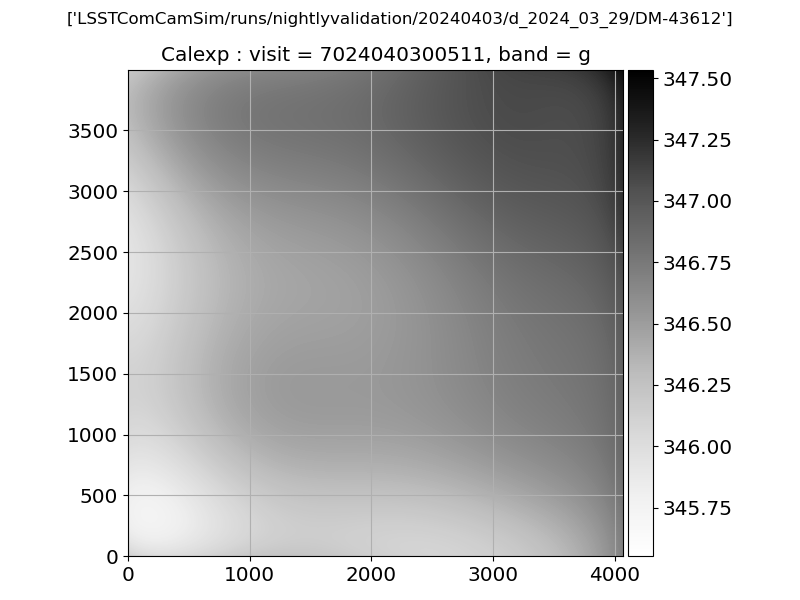

In [20]:
%matplotlib widget

bkgd = butler.get('calexpBackground', **dataId,collections=collections)
img = bkgd.getImage()
#wcs = img.getWcs()
#bbox = img.getBBox()
#corners_ra, corners_dec = get_corners_radec(wcs, bbox)
#extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


# Display the image with a suitable scaling
data_flat = img.array.flatten()
med = np.median(data_flat)
sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

fig,axs = plt.subplots(1,1,figsize=(8,6))
ax = axs
im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
plt.colorbar(im, cax=cax,ax=ax)


plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Many Background

In [21]:
df_myselectedvisits.tail(100)

ccdVisitId        visitId band  detector          ra       dec  \
0   730865988864  7024040300501    g         0  249.708048  2.048512   
1   730865989120  7024040300502    g         0  249.616472  2.046874   
2   730865989376  7024040300503    g         0  249.687413  2.117555   
3   730865989632  7024040300504    g         0  249.583330  1.958382   
4   730865989888  7024040300505    g         0  249.758460  1.877737   
5   730865990144  7024040300506    g         0  249.751384  2.175322   
6   730865990400  7024040300507    g         0  249.744381  2.137996   
7   730865990656  7024040300508    g         0  249.487923  1.930731   
8   730865990912  7024040300509    g         0  249.732088  1.824816   
9   730865991168  7024040300510    g         0  249.537205  2.050900   
10  730865991424  7024040300511    g         0  249.680108  2.045098   
11  730865991680  7024040300512    g         0  249.678324  1.780685   
12  730865991936  7024040300513    g         0  249.543738  1.833479   
13  730865992192  7024040300514    g         0  249.705941  1.912608   
14  730865992448  7024040300515    g         0  249.730844  1.874522   
15  730865992704  7024040300516    g         0  249.561160  2.097163   
16  730865992960  7024040300517    g         0  249.793677  1.858572   
17  730865993216  7024040300518    g         0  249.853843  1.863174   
18  730865993472  7024040300519    g         0  249.782928  1.937489   
19  730865993728  7024040300520    g         0  249.775259  1.771860   
20  730866019584  7024040300621    g         0  249.743608  1.987420   
21  730866019840  7024040300622    g         0  249.518512  1.914602   
22  730866020096  7024040300623    g         0  249.685694  2.022299   
23  730866020352  7024040300624    g         0  249.760912  2.079622   
24  730866020608  7024040300625    g         0  249.769639  2.024363   
25  730866020864  7024040300626    g         0  249.666083  1.800360   
26  730866021120  7024040300627    g         0  249.545472  1.796188   
27  730866021376  7024040300628    g         0  249.562309  1.874163   
28  730866021632  7024040300629    g         0  249.777977  1.993136   
29  730866021888  7024040300630    g         0  249.620840  1.838555   
30  730866022144  7024040300631    g         0  249.741588  1.923423   
31  730866022400  7024040300632    g         0  249.600599  1.932706   
32  730866022656  7024040300633    g         0  249.571341  1.986907   
33  730866022912  7024040300634    g         0  249.566190  2.022507   
34  730866023168  7024040300635    g         0  249.500851  1.911101   
35  730866023424  7024040300636    g         0  249.538592  1.933908   
36  730866023680  7024040300637    g         0  249.693581  1.769513   
37  730866023936  7024040300638    g         0  249.700929  1.915916   
38  730866024192  7024040300639    g         0  249.543803  1.741208   
39  730866024448  7024040300640    g         0  249.586583  1.730232   

         llcra    llcdec       ulcra    ulcdec       urcra    urcdec  \
0   249.550911  2.071215  249.733601  2.205147  249.865201  2.025790   
1   249.458868  2.066148  249.638614  2.204035  249.774107  2.027586   
2   249.529461  2.133728  249.706436  2.275122  249.845379  2.101370   
3   249.425101  1.971355  249.599161  2.116290  249.741577  1.945391   
4   249.600049  1.888185  249.771766  2.035882  249.916888  1.867277   
5   249.592741  2.181988  249.760912  2.333748  249.910045  2.168641   
6   249.585640  2.141505  249.750757  2.296573  249.903143  2.134470   
7   249.329159  1.930646  249.490700  2.089410  249.646700  1.930803   
8   249.573351  1.822448  249.732580  1.983515  249.890842  1.827165   
9   249.378578  2.044309  249.533471  2.209554  249.695864  2.057476   
10  249.521612  2.035740  249.673597  2.203663  249.838624  2.054446   
11  249.520040  1.768600  249.669082  1.939115  249.836632  1.792763   
12  249.385768  1.817664  249.530760  1.991644  249.701722  1.849276   
13  249.548285  1.893944  249.690105  2.07051

In [22]:
NROWS = 10
NCOLS = 4
NIMGS = NROWS*NCOLS
index0 = 0

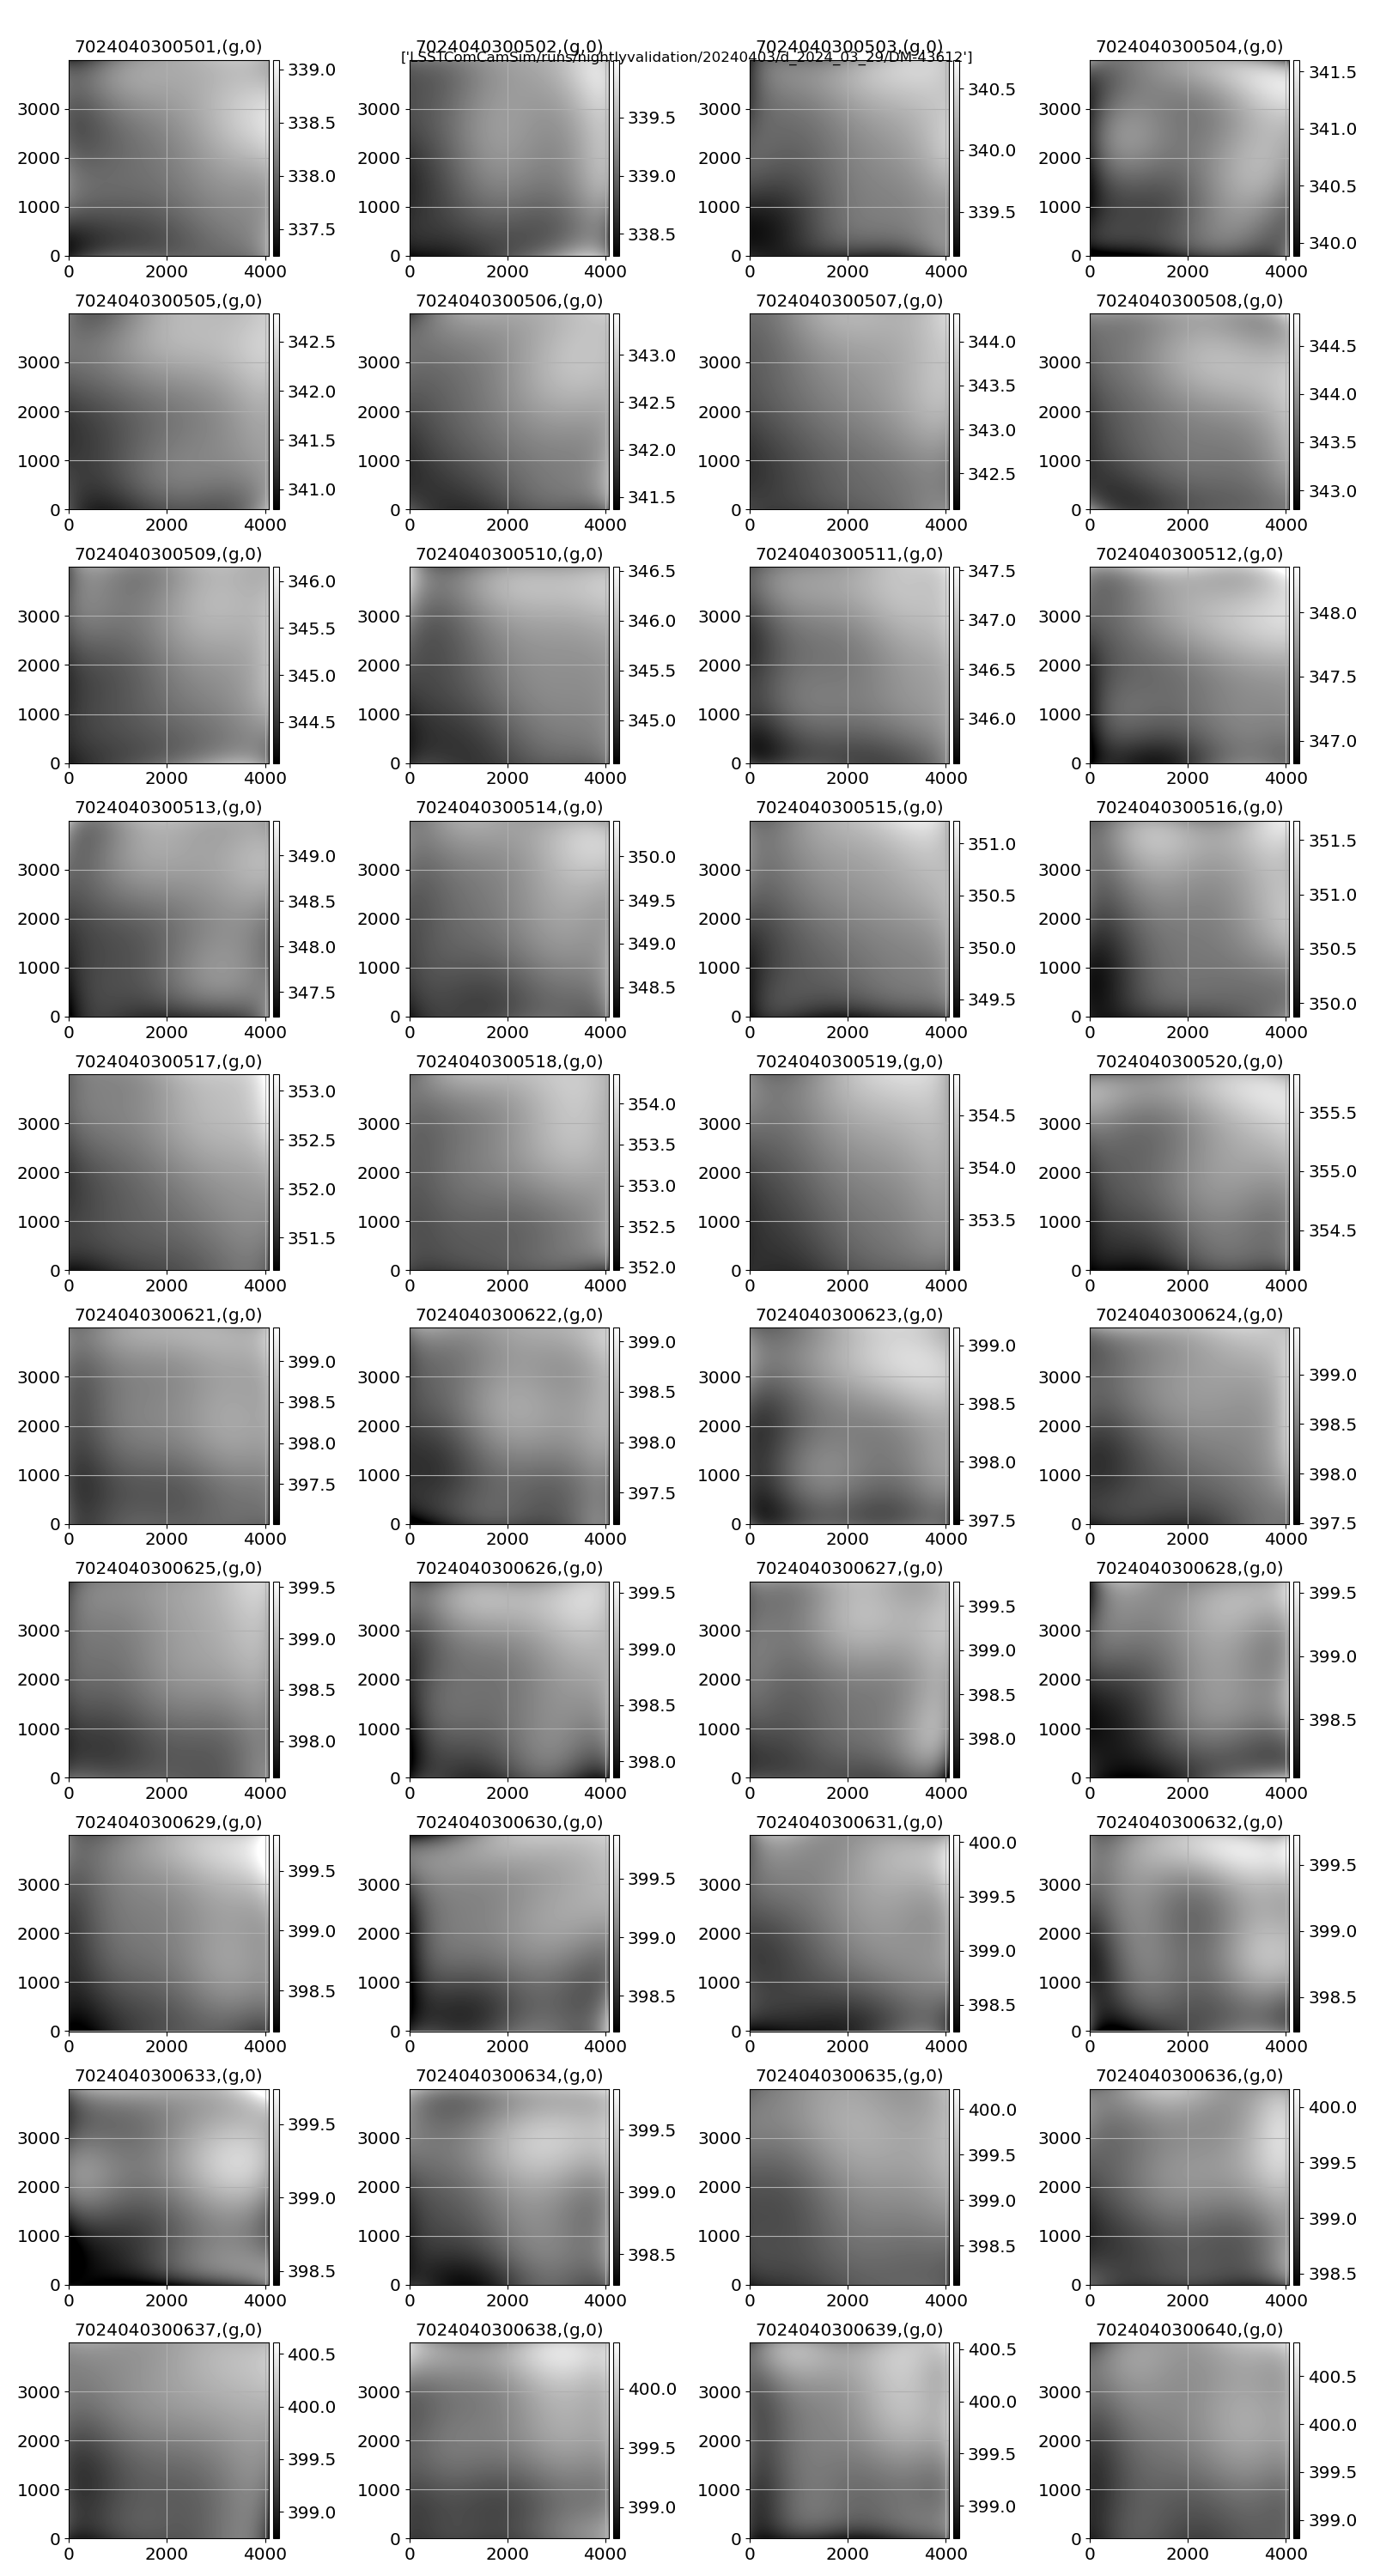

In [23]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*4,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    im=ax.imshow(img.array, origin="lower",vmin=vmin, vmax=vmax, cmap="grey")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    the_title = f"{visitId},({band},{detector})"
    ax.set_title(the_title)
    ax.grid()
    ax.set_aspect('equal')
    plt.colorbar(im, cax=cax,ax=ax)

plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Background flux (nJ)

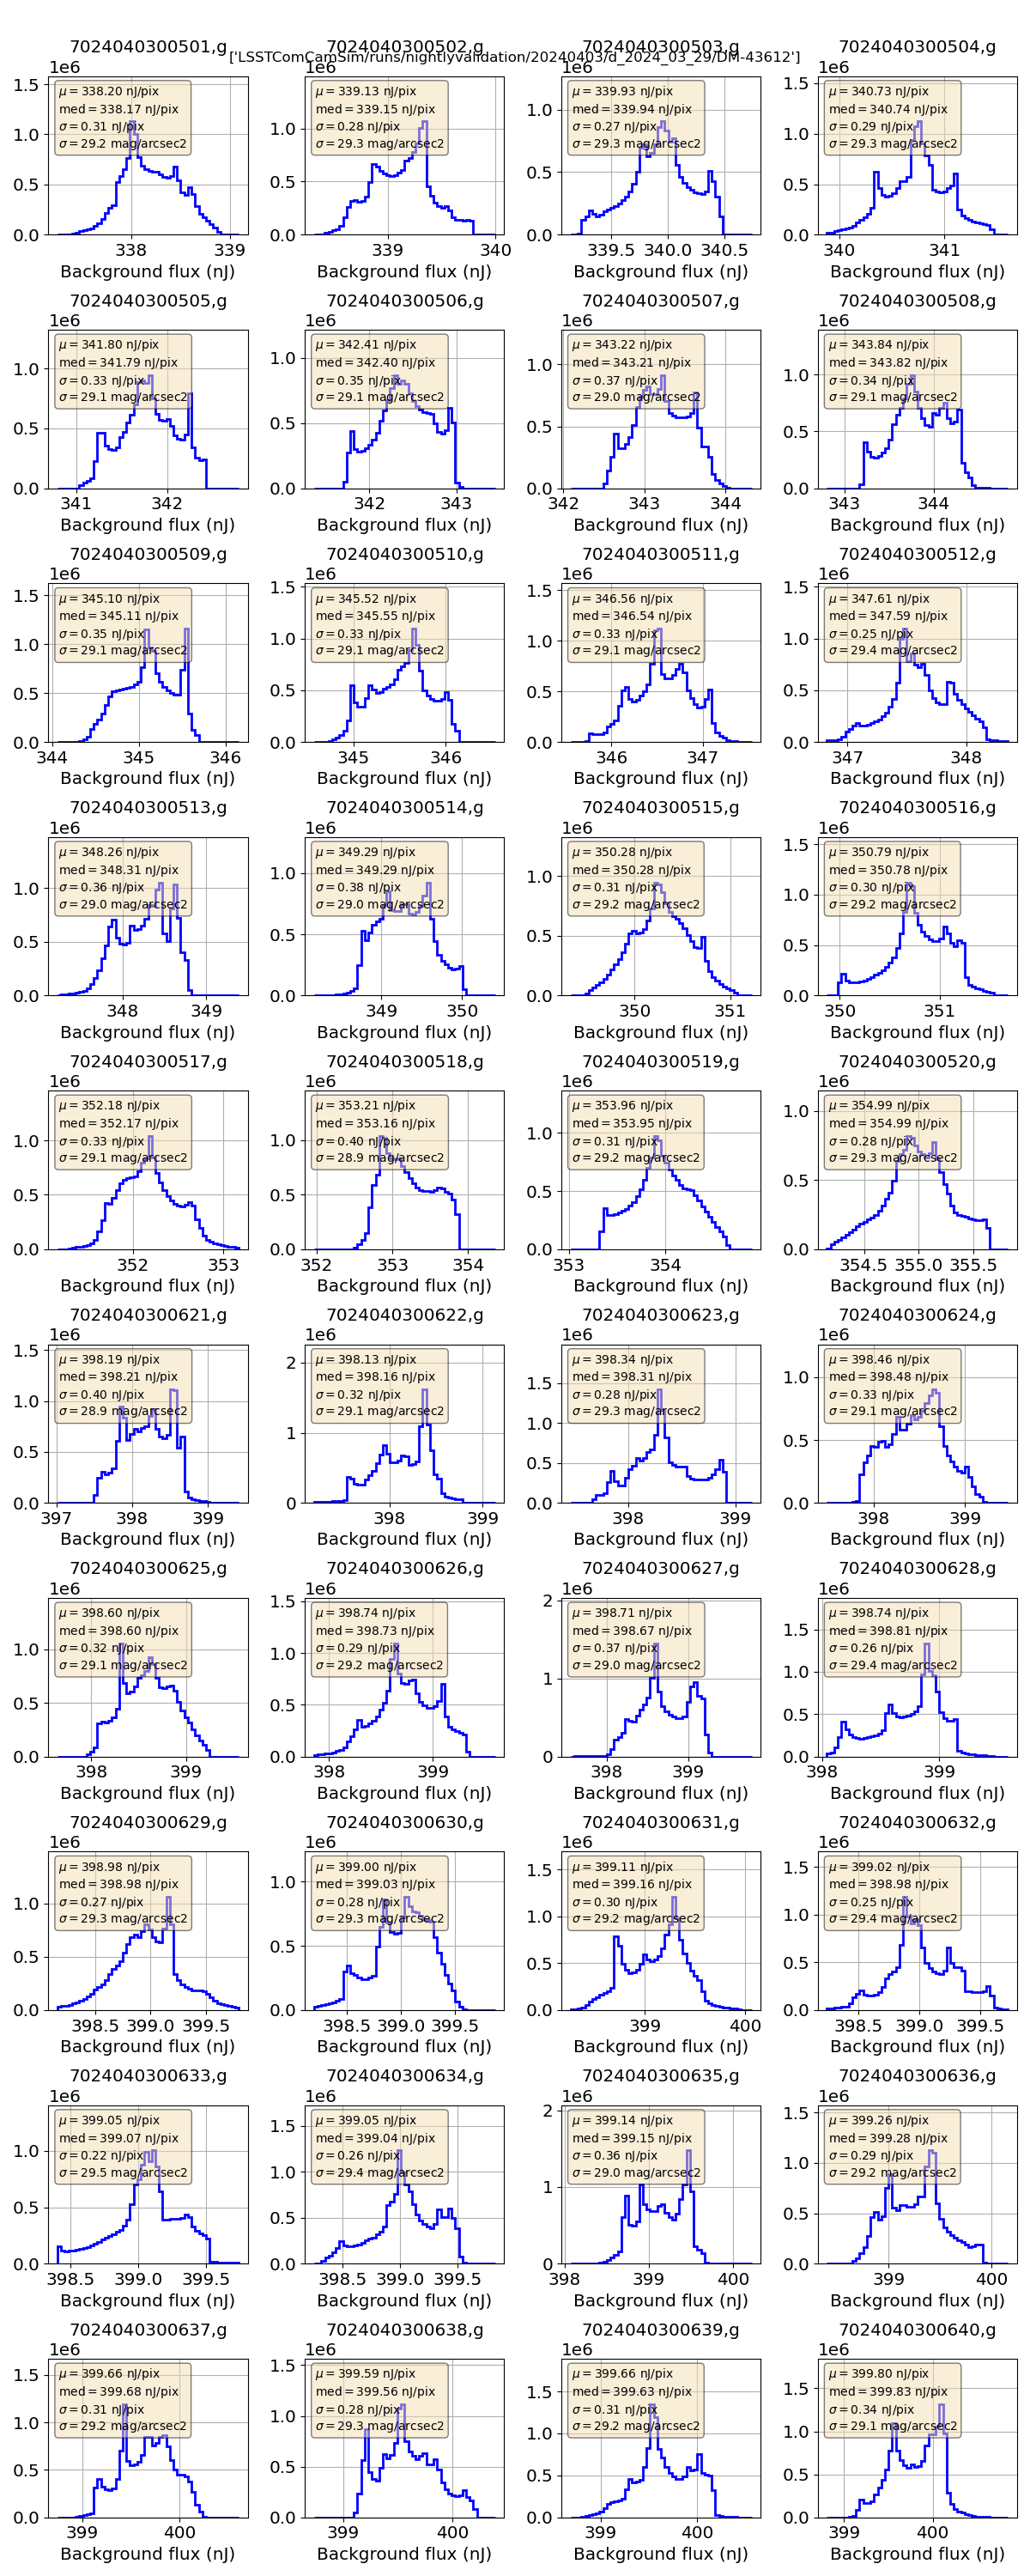

In [24]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    mu = np.mean(data_flat)
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    
    textstr = '\n'.join((
    r'$\mu=%.2f$ nJ/pix' % (mu, ),
    r'$\mathrm{med}=%.2f$ nJ/pix' % (med, ),
    r'$\sigma=%.2f$ nJ/pix' % (sigMad, ),
    r'$\sigma=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad/pixel_scale**2), )))

    histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.set_xlabel("Background flux (nJ)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*1.4)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Background flux (nJ) in not masked pixels

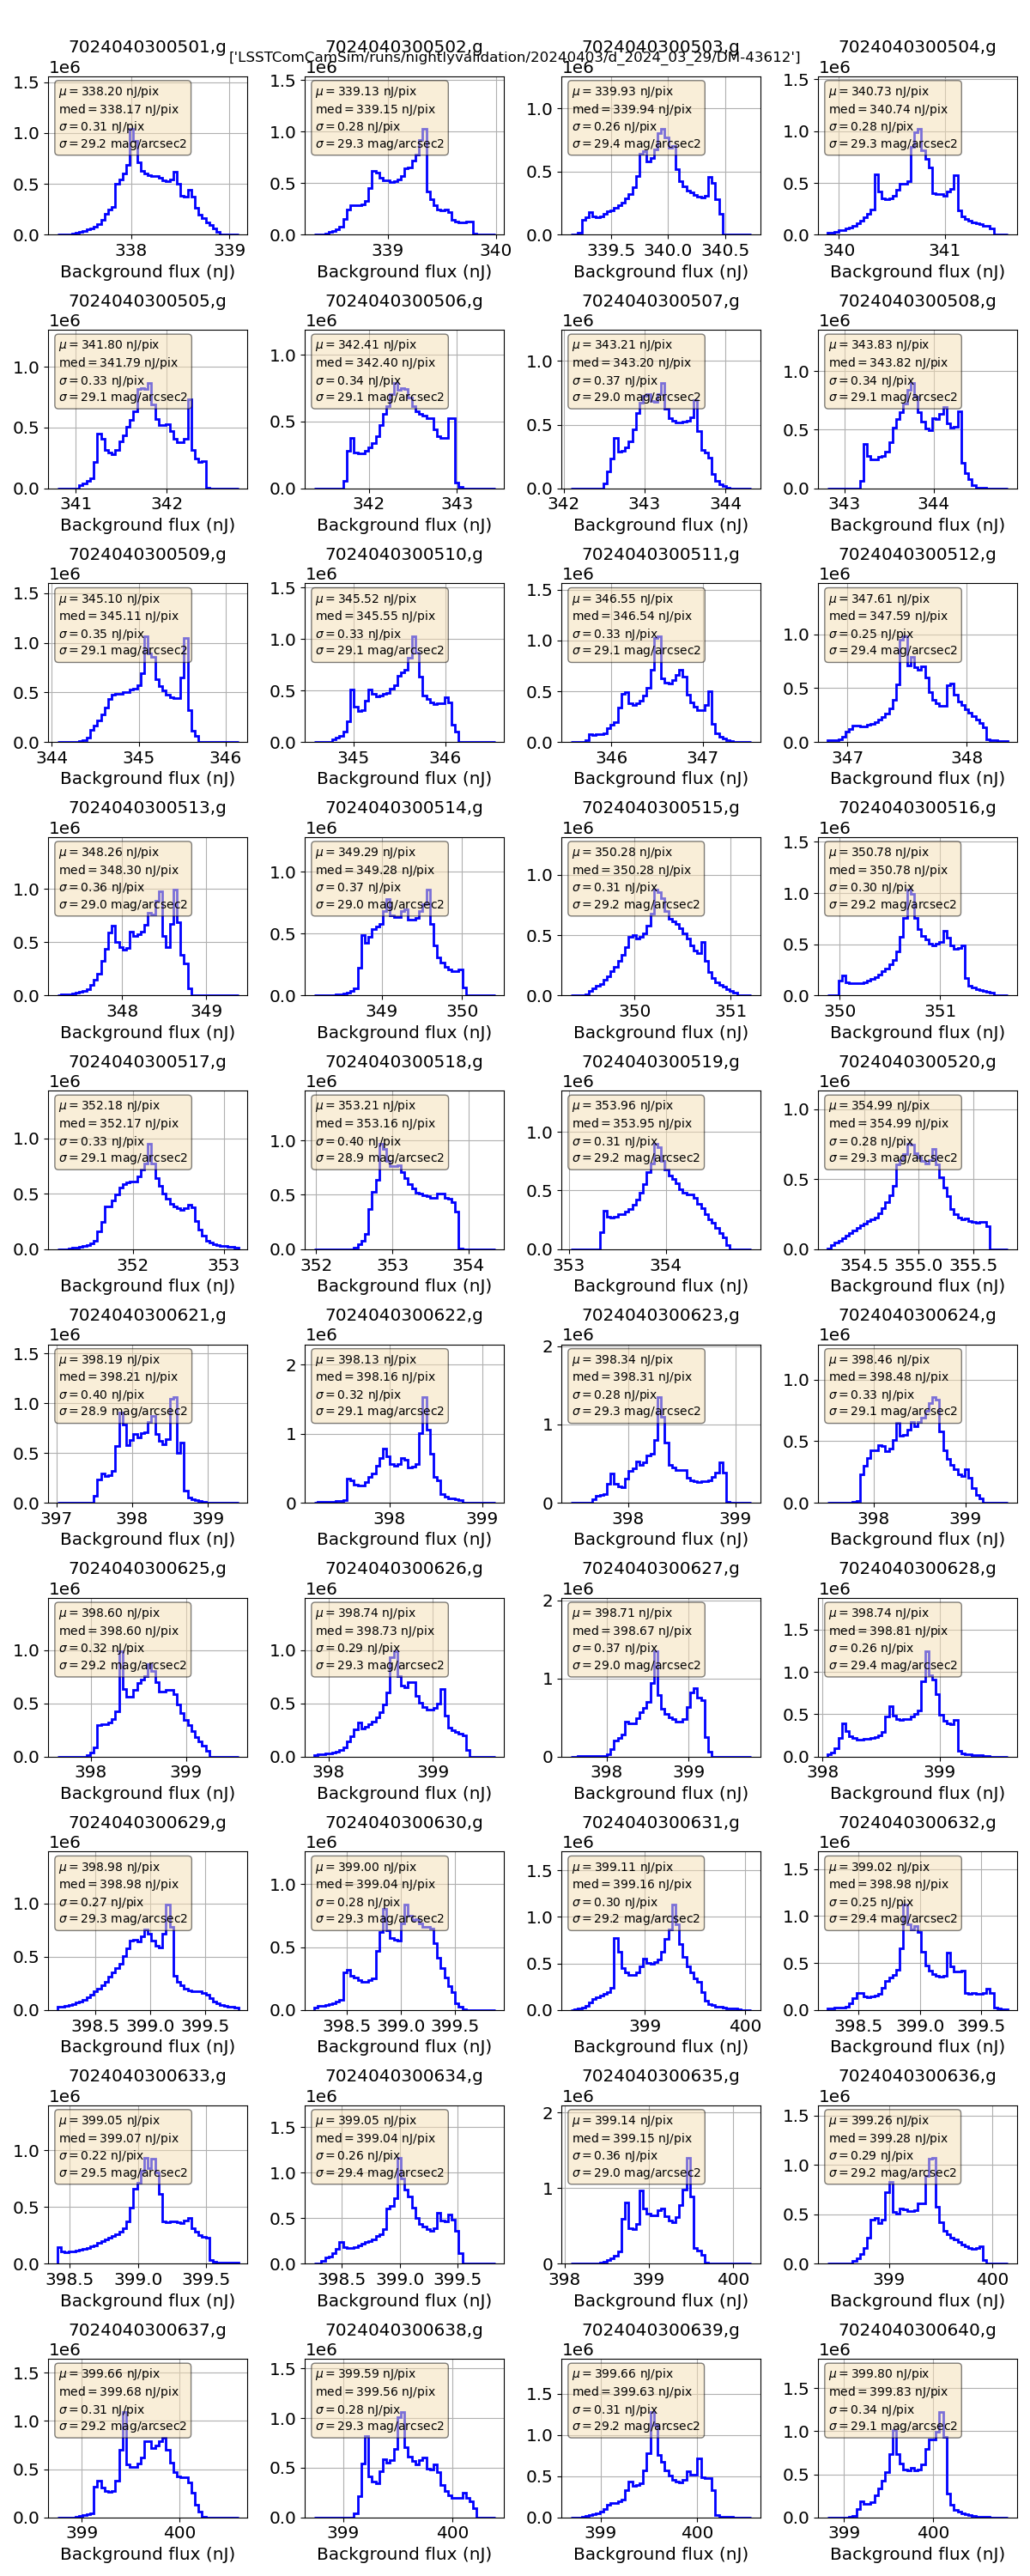

In [25]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    calexp = butler.get('calexp', **dataId,collections=collections)
    mask = calexp.mask.array
    the_mask = np.where(mask==0,1,0)
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage().array* the_mask

    data_flat = img.flatten()
    data_flat_nozero = data_flat[~(data_flat==0)]
    mu = np.mean(data_flat_nozero )
    med = np.median(data_flat_nozero )
    sigMad_nozero  = 1.4826 * np.median(np.fabs(data_flat_nozero  - med))
    vmin = med - 3 * sigMad_nozero 
    vmax = med + 3 * sigMad_nozero 

    
    textstr = '\n'.join((
    r'$\mu=%.2f$ nJ/pix' % (mu, ),
    r'$\mathrm{med}=%.2f$ nJ/pix' % (med, ),
    r'$\sigma=%.2f$ nJ/pix' % (sigMad_nozero , ),
    r'$\sigma=%.1f$ mag/arcsec2' % (convert_fluxtomag(sigMad_nozero/pixel_scale**2 ), )))

    histdata = ax.hist(data_flat,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},{band}"
    ax.set_title(the_title)
    ax.set_xlabel("Background flux (nJ)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*1.5)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

## Background in Mag

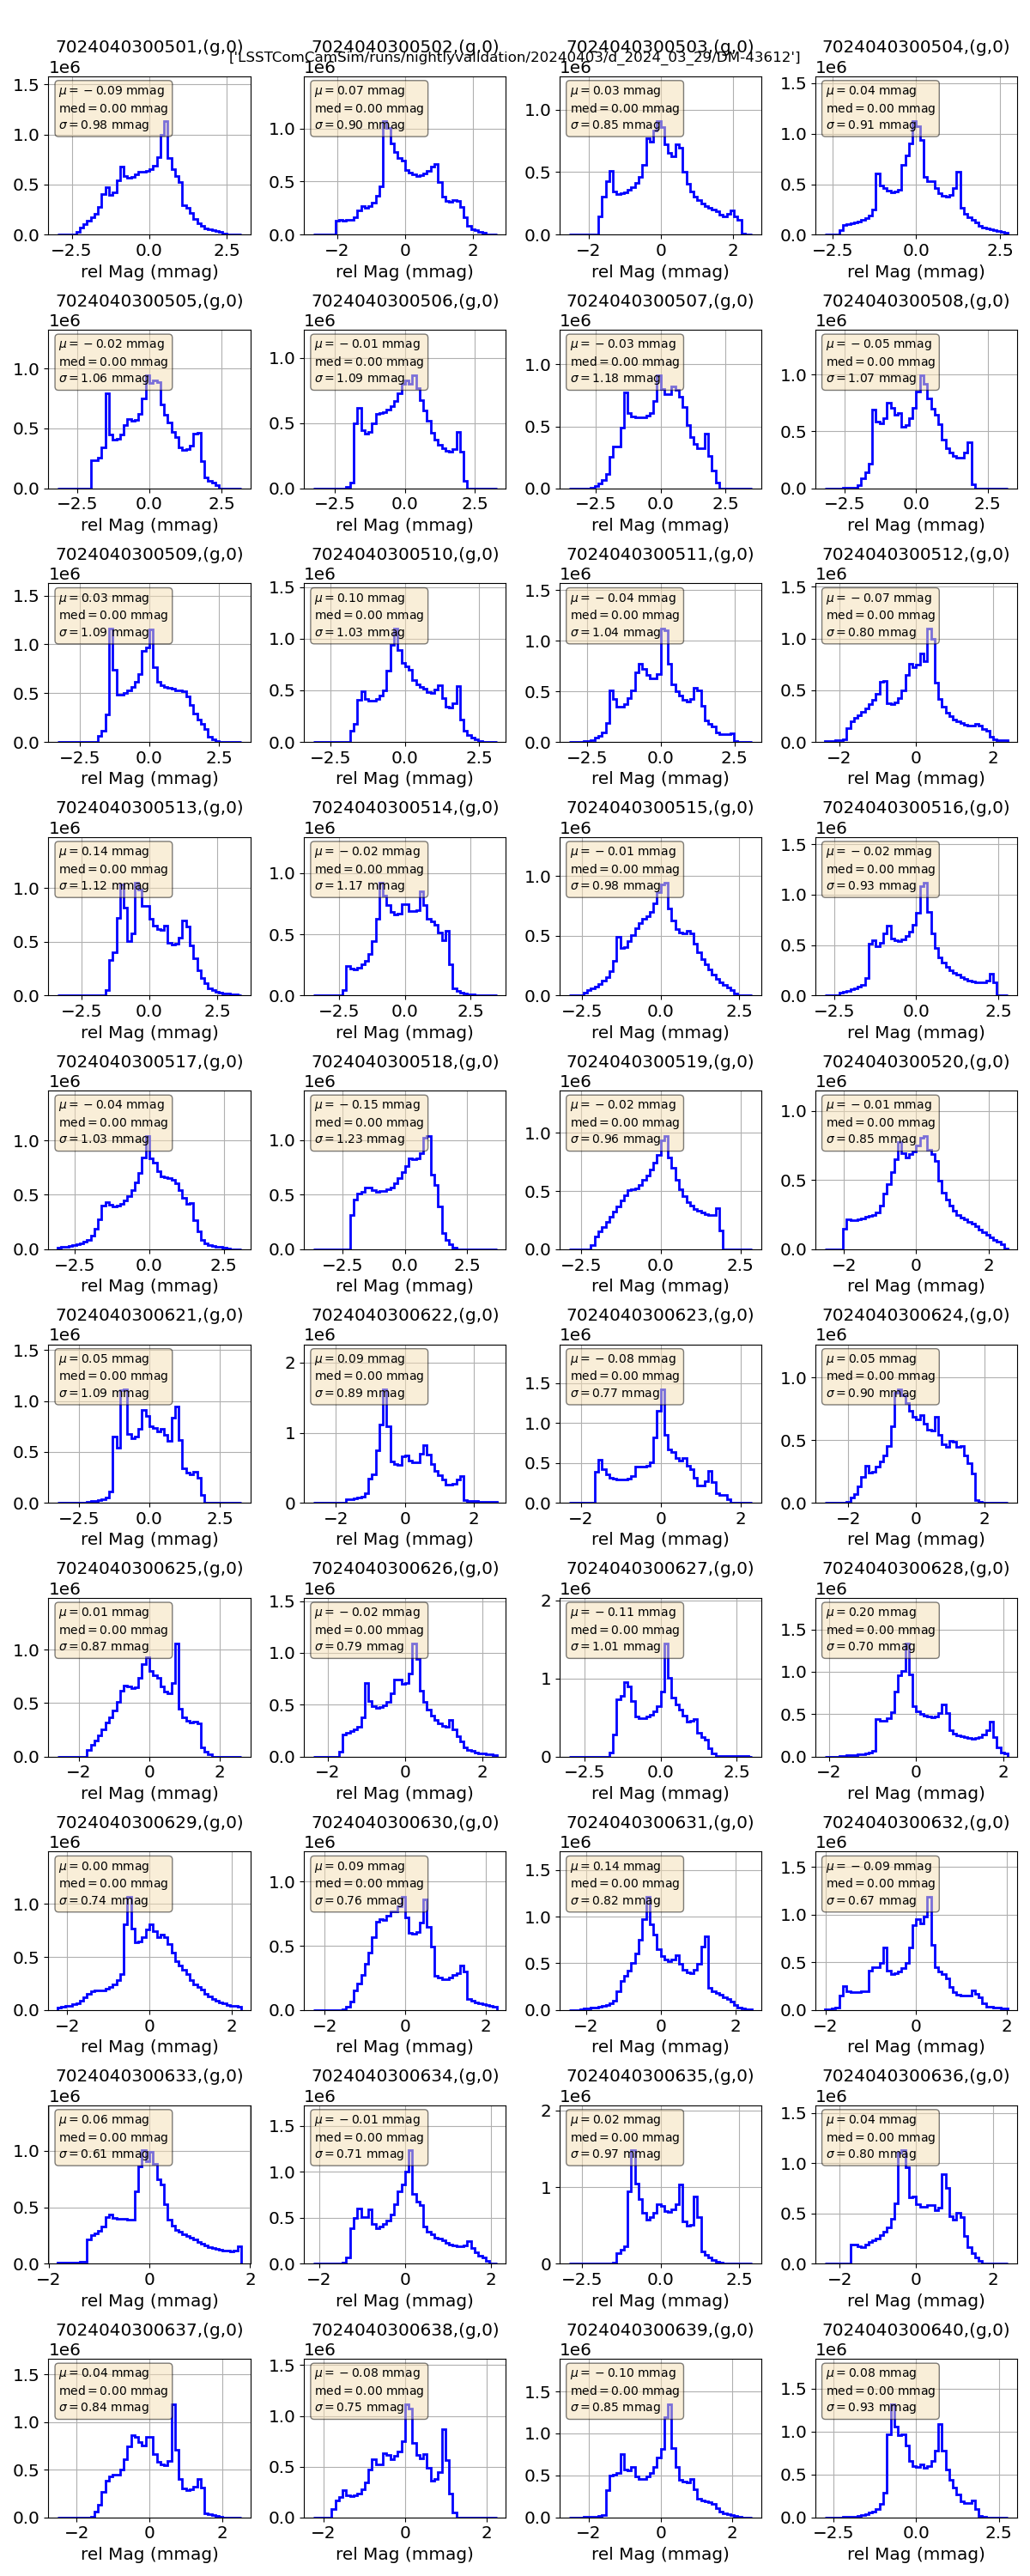

In [26]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))

for index,ax in enumerate(axs.flatten()):
    visitId = df_myselectedvisits.iloc[index0+index]['visitId']
    dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
    bkgd = butler.get('calexpBackground', **dataId,collections=collections)
    img = bkgd.getImage()

    data_flat = img.array.flatten()
    med = np.median(data_flat)
    sigMad = 1.4826 * np.median(np.fabs(data_flat - med))
    vmin = med - 3 * sigMad
    vmax = med + 3 * sigMad

    data_flat_mag = -2.5*np.log10((data_flat/med))*1000
    mu_mag = np.mean(data_flat_mag)
    med_mag = np.median(data_flat_mag)
    sigMad_mag = 1.4826 * np.median(np.fabs(data_flat_mag - med_mag))
    vmin = med_mag - 3 * sigMad_mag
    vmax = med_mag + 3 * sigMad_mag
    textstr = '\n'.join((
    r'$\mu=%.2f$ mmag' % (mu_mag, ),
    r'$\mathrm{med}=%.2f$ mmag' % (med_mag, ),
    r'$\sigma=%.2f$ mmag' % (sigMad_mag , )))

    histdata = ax.hist(data_flat_mag,bins=50,range=(vmin,vmax),histtype="step",color="b",lw=2)
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
    
    the_title = f"{visitId},({band},{detector})"
    ax.set_title(the_title)
    ax.set_xlabel("rel Mag (mmag)")
    ax.grid()
    ax.set_ylim(0.,histdata[0].max()*1.4)
  
plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)